In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os

# folder path
dir_path = '/content/drive/MyDrive/archive/BirdVsDrone-drone(2894)&bird(1252)/BirdVsDrone/Birds'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:',count)

File count: 1259


In [11]:
import os

def retain_files(folder_path, num_files_to_retain):
    # Get the list of files in the folder
    files = os.listdir(folder_path)

    # Sort the files to keep a consistent order
    files.sort()

    # Determine the number of files to delete
    num_files_to_delete = max(0, len(files) - num_files_to_retain)

    # Delete extra files
    for file_name in files[:num_files_to_delete]:
        file_path = os.path.join(folder_path, file_name)
        try:
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

if __name__ == "__main__":
    folder_path = '/content/drive/MyDrive/archive/BirdVsDrone-drone(2894)&bird(1252)/BirdVsDrone/Drones'  # Replace with the path to your folder
    num_files_to_retain = 1259

    retain_files(folder_path, num_files_to_retain)


Deleted: /content/drive/MyDrive/archive/BirdVsDrone-drone(2894)&bird(1252)/BirdVsDrone/Drones/1(1).JPEG
Deleted: /content/drive/MyDrive/archive/BirdVsDrone-drone(2894)&bird(1252)/BirdVsDrone/Drones/1.jpeg
Deleted: /content/drive/MyDrive/archive/BirdVsDrone-drone(2894)&bird(1252)/BirdVsDrone/Drones/10(1).JPEG
Deleted: /content/drive/MyDrive/archive/BirdVsDrone-drone(2894)&bird(1252)/BirdVsDrone/Drones/10.jpeg
Deleted: /content/drive/MyDrive/archive/BirdVsDrone-drone(2894)&bird(1252)/BirdVsDrone/Drones/100(1).JPEG
Deleted: /content/drive/MyDrive/archive/BirdVsDrone-drone(2894)&bird(1252)/BirdVsDrone/Drones/100.jpeg
Deleted: /content/drive/MyDrive/archive/BirdVsDrone-drone(2894)&bird(1252)/BirdVsDrone/Drones/101(1).JPEG
Deleted: /content/drive/MyDrive/archive/BirdVsDrone-drone(2894)&bird(1252)/BirdVsDrone/Drones/101.jpeg
Deleted: /content/drive/MyDrive/archive/BirdVsDrone-drone(2894)&bird(1252)/BirdVsDrone/Drones/102(1).JPEG
Deleted: /content/drive/MyDrive/archive/BirdVsDrone-drone(2894)&

In [12]:
import os

# folder path
dir_path = '/content/drive/MyDrive/archive/BirdVsDrone-drone(2894)&bird(1252)/BirdVsDrone/Drones'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:',count)

File count: 1259


In [15]:
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet152V2
from keras import layers, models
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K

# Define paths
base_path = '/content/drive/MyDrive/archive/BirdVsDrone-drone(2894)&bird(1252)/BirdVsDrone'
birds_path = os.path.join(base_path, 'Birds')
drones_path = os.path.join(base_path, 'Drones')

# List all files in the folders
birds_files = [os.path.join(birds_path, file) for file in os.listdir(birds_path)]
drones_files = [os.path.join(drones_path, file) for file in os.listdir(drones_path)]

# Create labels
birds_labels = [0] * len(birds_files)
drones_labels = [1] * len(drones_files)

# Combine data and labels
all_data_paths = birds_files + drones_files
all_labels = birds_labels + drones_labels

# Split data into training, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_data_paths, all_labels, test_size=0.2, random_state=42
)

# Further split the validation set
validation_paths, test_paths, validation_labels, test_labels = train_test_split(
    test_paths, test_labels, test_size=0.5, random_state=42
)

# Convert labels to strings
train_labels = [str(label) for label in train_labels]
validation_labels = [str(label) for label in validation_labels]
test_labels = [str(label) for label in test_labels]

# Create dataframes for train, validation, and test sets
train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
validation_df = pd.DataFrame({'path': validation_paths, 'label': validation_labels})
test_df = pd.DataFrame({'path': test_paths, 'label': test_labels})

# Use ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators from dataframes
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    validation_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

# Create data generators from dataframes for the test set with shuffle=False
test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False  # Disable shuffling for the test set
)

# Define the base model (ResNet152V2)
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
# Unfreeze the last 10 layers in the base model
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Custom F1 score metric
def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1_val

# Create a custom model for classification
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with the custom F1 metric
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy', f1_metric])

# Set up callbacks with 'val_f1' monitoring
checkpoint_path = '/content/drive/MyDrive/archive/BirdVsDrone-drone(2894)&bird(1252)/BirdVsDrone/model_checkpoint4(Resnet152V2).h5'
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_f1',  # Change to 'val_f1' for monitoring F1 score
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=60,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy, test_f1 = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')
print(f'Test F1 Score: {test_f1}')

# Make predictions on the test set
test_predictions = model.predict(test_generator)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Convert labels to binary format
test_labels_binary = test_df['label'].astype(int)

# Calculate F1 score
f1 = f1_score(test_labels_binary, test_predictions_binary)
print(f'F1 Score: {f1}')

# Display classification report
print('Classification Report:\n', classification_report(test_labels_binary, test_predictions_binary))


Found 2013 validated image filenames belonging to 2 classes.
Found 251 validated image filenames belonging to 2 classes.
Found 252 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/60
 17/125 [===>..........................] - ETA: 30s - loss: 0.8282 - accuracy: 0.8382 - f1_metric: 0.8510

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


125/125 [==============================] - ETA: 0s - loss: 0.4106 - accuracy: 0.9134 - f1_metric: 0.9098

125/125 [==============================] - 81s 450ms/step - loss: 0.4106 - accuracy: 0.9134 - f1_metric: 0.9098 - val_loss: 0.4316 - val_accuracy: 0.9667 - val_f1_metric: 0.9632 - lr: 0.0010
Epoch 2/60
125/125 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.9534 - f1_metric: 0.9499

125/125 [==============================] - 53s 426ms/step - loss: 0.1392 - accuracy: 0.9534 - f1_metric: 0.9499 - val_loss: 0.6297 - val_accuracy: 0.9542 - val_f1_metric: 0.9575 - lr: 0.0010
Epoch 3/60
125/125 [==============================] - ETA: 0s - loss: 0.3897 - accuracy: 0.9439 - f1_metric: 0.9379

125/125 [==============================] - 47s 379ms/step - loss: 0.3897 - accuracy: 0.9439 - f1_metric: 0.9379 - val_loss: 0.4758 - val_accuracy: 0.9583 - val_f1_metric: 0.9588 - lr: 0.0010
Epoch 4/60
125/125 [==============================] - ETA: 0s - loss: 0.6285 - accuracy: 0.9504 - f1_metric: 0.9477

125/125 [==============================] - 48s 381ms/step - loss: 0.6285 - accuracy: 0.9504 - f1_metric: 0.9477 - val_loss: 0.3001 - val_accuracy: 0.9625 - val_f1_metric: 0.9573 - lr: 0.0010
Epoch 5/60
125/125 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9670 - f1_metric: 0.9626

125/125 [==============================] - 47s 376ms/step - loss: 0.1207 - accuracy: 0.9670 - f1_metric: 0.9626 - val_loss: 0.3177 - val_accuracy: 0.9583 - val_f1_metric: 0.9573 - lr: 0.0010
Epoch 6/60
125/125 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.9579 - f1_metric: 0.9547

125/125 [==============================] - 48s 387ms/step - loss: 0.1452 - accuracy: 0.9579 - f1_metric: 0.9547 - val_loss: 0.0592 - val_accuracy: 0.9833 - val_f1_metric: 0.9846 - lr: 0.0010
Epoch 7/60
125/125 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9690 - f1_metric: 0.9671

125/125 [==============================] - 47s 378ms/step - loss: 0.1137 - accuracy: 0.9690 - f1_metric: 0.9671 - val_loss: 0.0754 - val_accuracy: 0.9750 - val_f1_metric: 0.9737 - lr: 0.0010
Epoch 8/60
125/125 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9715 - f1_metric: 0.9709

125/125 [==============================] - 47s 376ms/step - loss: 0.0802 - accuracy: 0.9715 - f1_metric: 0.9709 - val_loss: 0.0975 - val_accuracy: 0.9708 - val_f1_metric: 0.9685 - lr: 0.0010
Epoch 9/60
125/125 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9765 - f1_metric: 0.9758

125/125 [==============================] - 49s 389ms/step - loss: 0.0755 - accuracy: 0.9765 - f1_metric: 0.9758 - val_loss: 0.0870 - val_accuracy: 0.9833 - val_f1_metric: 0.9846 - lr: 0.0010
Epoch 10/60
125/125 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9710 - f1_metric: 0.9706

125/125 [==============================] - 48s 379ms/step - loss: 0.0877 - accuracy: 0.9710 - f1_metric: 0.9706 - val_loss: 0.0623 - val_accuracy: 0.9833 - val_f1_metric: 0.9816 - lr: 0.0010
Epoch 11/60
125/125 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9800 - f1_metric: 0.9779

125/125 [==============================] - 48s 380ms/step - loss: 0.0506 - accuracy: 0.9800 - f1_metric: 0.9779 - val_loss: 0.0733 - val_accuracy: 0.9833 - val_f1_metric: 0.9846 - lr: 0.0010
Epoch 12/60
125/125 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9865 - f1_metric: 0.9832

125/125 [==============================] - 48s 380ms/step - loss: 0.0534 - accuracy: 0.9865 - f1_metric: 0.9832 - val_loss: 0.0683 - val_accuracy: 0.9833 - val_f1_metric: 0.9846 - lr: 2.0000e-04
Epoch 13/60
125/125 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9840 - f1_metric: 0.9828

125/125 [==============================] - 47s 377ms/step - loss: 0.0414 - accuracy: 0.9840 - f1_metric: 0.9828 - val_loss: 0.0797 - val_accuracy: 0.9875 - val_f1_metric: 0.9890 - lr: 2.0000e-04
Epoch 14/60
125/125 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9875 - f1_metric: 0.9868

125/125 [==============================] - 48s 380ms/step - loss: 0.0336 - accuracy: 0.9875 - f1_metric: 0.9868 - val_loss: 0.0657 - val_accuracy: 0.9875 - val_f1_metric: 0.9855 - lr: 2.0000e-04
Epoch 15/60
125/125 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9885 - f1_metric: 0.9875

125/125 [==============================] - 48s 380ms/step - loss: 0.0431 - accuracy: 0.9885 - f1_metric: 0.9875 - val_loss: 0.0598 - val_accuracy: 0.9833 - val_f1_metric: 0.9826 - lr: 2.0000e-04
Epoch 16/60
125/125 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9875 - f1_metric: 0.9867

125/125 [==============================] - 47s 378ms/step - loss: 0.0363 - accuracy: 0.9875 - f1_metric: 0.9867 - val_loss: 0.0733 - val_accuracy: 0.9875 - val_f1_metric: 0.9855 - lr: 2.0000e-04
Epoch 17/60
125/125 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9940 - f1_metric: 0.9907

125/125 [==============================] - 48s 380ms/step - loss: 0.0215 - accuracy: 0.9940 - f1_metric: 0.9907 - val_loss: 0.0761 - val_accuracy: 0.9917 - val_f1_metric: 0.9929 - lr: 4.0000e-05
Epoch 18/60
125/125 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9875 - f1_metric: 0.9867

125/125 [==============================] - 48s 380ms/step - loss: 0.0877 - accuracy: 0.9875 - f1_metric: 0.9867 - val_loss: 0.0749 - val_accuracy: 0.9917 - val_f1_metric: 0.9929 - lr: 4.0000e-05
Epoch 19/60
125/125 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.9910 - f1_metric: 0.9896

125/125 [==============================] - 53s 421ms/step - loss: 0.0254 - accuracy: 0.9910 - f1_metric: 0.9896 - val_loss: 0.0712 - val_accuracy: 0.9875 - val_f1_metric: 0.9855 - lr: 4.0000e-05
Epoch 20/60
125/125 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9910 - f1_metric: 0.9908

125/125 [==============================] - 48s 384ms/step - loss: 0.0268 - accuracy: 0.9910 - f1_metric: 0.9908 - val_loss: 0.0697 - val_accuracy: 0.9875 - val_f1_metric: 0.9855 - lr: 4.0000e-05
Epoch 21/60
125/125 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9925 - f1_metric: 0.9922

Restoring model weights from the end of the best epoch: 6.
125/125 [==============================] - 48s 380ms/step - loss: 0.0312 - accuracy: 0.9925 - f1_metric: 0.9922 - val_loss: 0.0678 - val_accuracy: 0.9833 - val_f1_metric: 0.9826 - lr: 4.0000e-05
Epoch 21: early stopping
16/16 [==============================] - 4s 239ms/step - loss: 0.0763 - accuracy: 0.9683 - f1_metric: 0.9703
Test Accuracy: 0.9682539701461792
Test Loss: 0.07627474516630173
Test F1 Score: 0.9702829122543335
16/16 [==============================] - 5s 125ms/step
F1 Score: 0.968
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       124
           1       0.99      0.95      0.97       128

    accuracy                           0.97       252
   macro avg       0.97      0.97      0.97       252
weighted avg       0.97      0.97      0.97       252



11/16 [===================>..........] - ETA: 1s - loss: 0.0758 - accuracy: 0.9716 - f1_metric: 0.9707

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16/16 [==============================] - 4s 253ms/step - loss: 0.0763 - accuracy: 0.9683 - f1_metric: 0.9703
Test Accuracy: 0.9682539701461792
Test Loss: 0.07627474516630173
Test F1 Score: 0.9702829122543335
16/16 [==============================] - 4s 213ms/step
F1 Score: 0.968
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       124
           1       0.99      0.95      0.97       128

    accuracy                           0.97       252
   macro avg       0.97      0.97      0.97       252
weighted avg       0.97      0.97      0.97       252



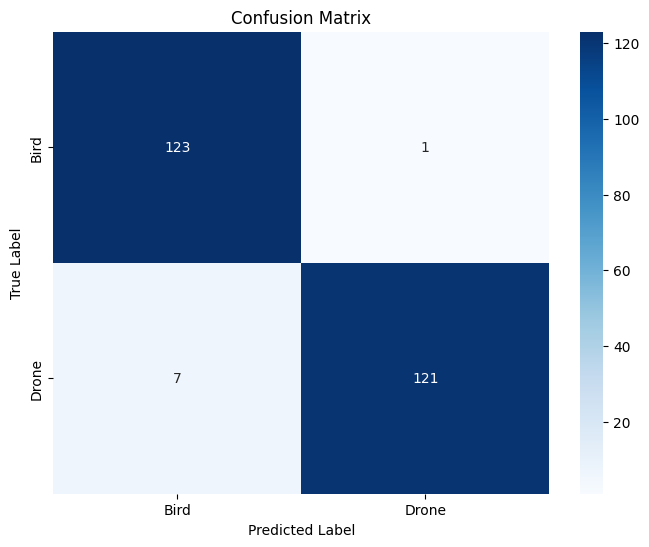

In [16]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ... (previous code)

# Evaluate the model on the test set
test_loss, test_accuracy, test_f1 = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')
print(f'Test F1 Score: {test_f1}')

# Make predictions on the test set
test_predictions = model.predict(test_generator)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Convert labels to binary format
test_labels_binary = test_df['label'].astype(int)

# Calculate F1 score
f1 = f1_score(test_labels_binary, test_predictions_binary)
print(f'F1 Score: {f1}')

# Display classification report
print('Classification Report:\n', classification_report(test_labels_binary, test_predictions_binary))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_binary, test_predictions_binary)
class_names = ['Bird', 'Drone']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
